In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rgan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 125
LR = 5e-5 
IN_SHAPE = config["image_shape"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.1 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_1/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_1/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_1/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Models and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
disc_models = [rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE//(MAGNIFICATION*N_MAG), latent_channel_count=8).to(device),]
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, discriminators=disc_models, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Generator network parameters: {alpha_params/1e6}1e6")
param_list = []
for model in disc_models:
    param_list += list(model.parameters())
disc_opt = torch.optim.Adam(params=param_list,lr=LR)
for i,model in zip(range(3),disc_models):
    params = sum(p.numel() for p in model.parameters())
    print(f"Discriminator network {i} parameters: {params/1e6}e6")

Generator network parameters: 0.9004221e6
Discriminator network 0 parameters: 0.223153e6
Discriminator network 1 parameters: 0.069553e6
Discriminator network 2 parameters: 0.036785e6


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE)
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


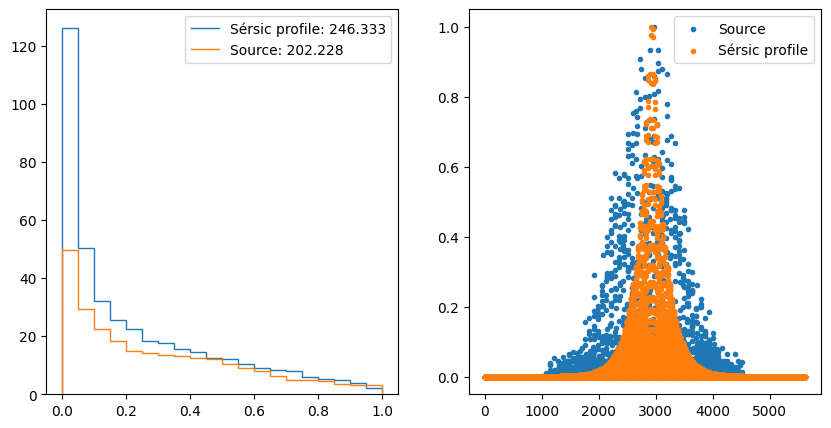

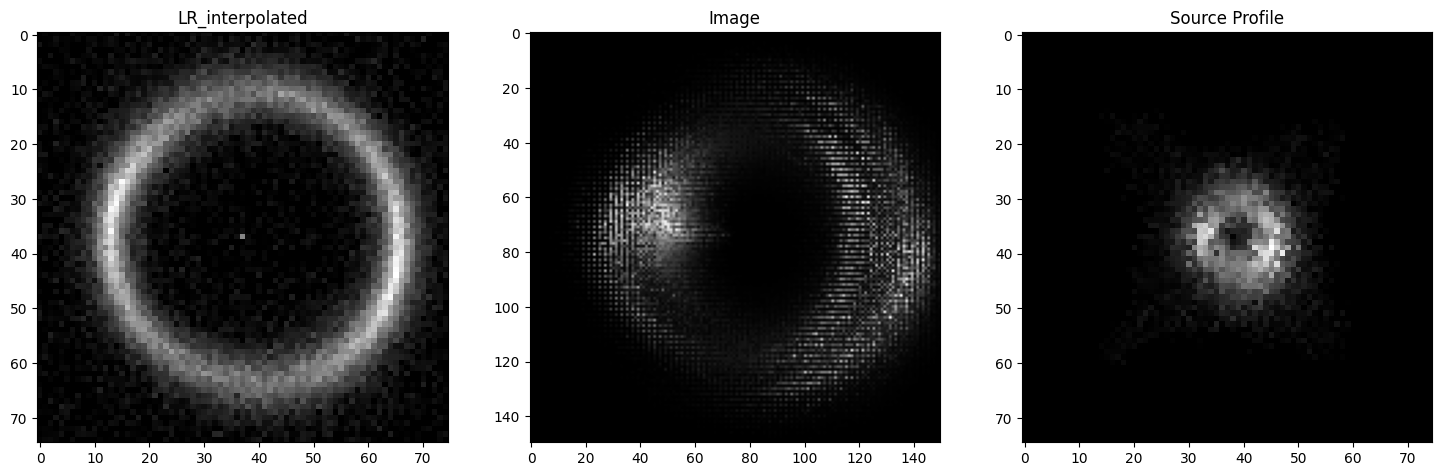

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'ad_loss':[], 'ad_val_loss':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    ad_losses = []
    alpha_model.train()
    for model in disc_models:
        model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual, ad_loss = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        disc_opt.zero_grad()
        ad_loss.backward()
        disc_opt.step()
        ad_losses.append(float(ad_loss))
        for key in individual_losses.keys():
            if history_individual[key] != []:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    for model in disc_models:
        model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    ad_losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual, ad_val_loss = lens_loss(alpha, x)
        losses.append(float(val_loss))
        ad_losses.append(float(ad_val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != []:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1:   0%|          | 0/816 [00:00<?, ?it/s]

Training epoch 1: 100%|██████████| 816/816 [01:04<00:00, 12.57it/s]


Training at epoch 1/125: 0.036680922464595415 at LR=5e-05


Validation epoch 1: 100%|██████████| 204/204 [00:07<00:00, 28.07it/s]


Validation at epoch 1/125: 0.03270812463882726 at LR=5e-05


Training epoch 2: 100%|██████████| 816/816 [01:06<00:00, 12.18it/s]


Training at epoch 2/125: 0.02232511971869469 at LR=5e-05


Validation epoch 2: 100%|██████████| 204/204 [00:07<00:00, 28.44it/s]


Validation at epoch 2/125: 0.04231914142877156 at LR=5e-05


Training epoch 3: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 3/125: 0.010316694141639507 at LR=5e-05


Validation epoch 3: 100%|██████████| 204/204 [00:07<00:00, 27.55it/s]


Validation at epoch 3/125: 0.016237114113298992 at LR=5e-05


Training epoch 4: 100%|██████████| 816/816 [01:09<00:00, 11.78it/s]


Training at epoch 4/125: 0.00769112834149935 at LR=5e-05


Validation epoch 4: 100%|██████████| 204/204 [00:08<00:00, 24.93it/s]


Validation at epoch 4/125: 0.01015946251687174 at LR=5e-05


Training epoch 5: 100%|██████████| 816/816 [01:09<00:00, 11.78it/s]


Training at epoch 5/125: 0.007123061089991027 at LR=5e-05


Validation epoch 5: 100%|██████████| 204/204 [00:07<00:00, 27.67it/s]


Validation at epoch 5/125: 0.009574377468750611 at LR=5e-05


Training epoch 6: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 6/125: 0.006781486200862656 at LR=5e-05


Validation epoch 6: 100%|██████████| 204/204 [00:07<00:00, 27.69it/s]


Validation at epoch 6/125: 0.006359122762018267 at LR=5e-05


Training epoch 7: 100%|██████████| 816/816 [01:07<00:00, 12.09it/s]


Training at epoch 7/125: 0.006347381256465965 at LR=5e-05


Validation epoch 7: 100%|██████████| 204/204 [00:07<00:00, 27.50it/s]


Validation at epoch 7/125: 0.006191820785056288 at LR=5e-05


Training epoch 8: 100%|██████████| 816/816 [01:06<00:00, 12.27it/s]


Training at epoch 8/125: 0.006283041945197528 at LR=5e-05


Validation epoch 8: 100%|██████████| 204/204 [00:07<00:00, 27.08it/s]


Validation at epoch 8/125: 0.006065304160538112 at LR=5e-05


Training epoch 9: 100%|██████████| 816/816 [01:07<00:00, 12.09it/s]


Training at epoch 9/125: 0.0061114350397724155 at LR=5e-05


Validation epoch 9: 100%|██████████| 204/204 [00:07<00:00, 26.99it/s]


Validation at epoch 9/125: 0.005495092247192765 at LR=5e-05


Training epoch 10: 100%|██████████| 816/816 [01:08<00:00, 11.94it/s]


Training at epoch 10/125: 0.005869143289244532 at LR=5e-05


Validation epoch 10: 100%|██████████| 204/204 [00:07<00:00, 26.86it/s]


Validation at epoch 10/125: 0.005662394908950756 at LR=5e-05


Training epoch 11: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 11/125: 0.005740051595471325 at LR=5e-05


Validation epoch 11: 100%|██████████| 204/204 [00:07<00:00, 27.36it/s]


Validation at epoch 11/125: 0.005317783202318584 at LR=5e-05


Training epoch 12: 100%|██████████| 816/816 [01:08<00:00, 11.98it/s]


Training at epoch 12/125: 0.005601939228511707 at LR=5e-05


Validation epoch 12: 100%|██████████| 204/204 [00:07<00:00, 26.20it/s]


Validation at epoch 12/125: 0.005076366603401872 at LR=5e-05


Training epoch 13: 100%|██████████| 816/816 [01:08<00:00, 11.98it/s]


Training at epoch 13/125: 0.005462656618214634 at LR=5e-05


Validation epoch 13: 100%|██████████| 204/204 [00:07<00:00, 26.69it/s]


Validation at epoch 13/125: 0.00502411060961986 at LR=5e-05


Training epoch 14: 100%|██████████| 816/816 [01:07<00:00, 12.05it/s]


Training at epoch 14/125: 0.005305025959958085 at LR=5e-05


Validation epoch 14: 100%|██████████| 204/204 [00:07<00:00, 27.19it/s]


Validation at epoch 14/125: 0.005434464114289 at LR=5e-05


Training epoch 15: 100%|██████████| 816/816 [01:07<00:00, 12.03it/s]


Training at epoch 15/125: 0.005323683155652628 at LR=5e-05


Validation epoch 15: 100%|██████████| 204/204 [00:07<00:00, 27.66it/s]


Validation at epoch 15/125: 0.005343139214970755 at LR=5e-05


Training epoch 16: 100%|██████████| 816/816 [01:07<00:00, 12.02it/s]


Training at epoch 16/125: 0.005346305926579197 at LR=5e-05


Validation epoch 16: 100%|██████████| 204/204 [00:07<00:00, 26.96it/s]


Validation at epoch 16/125: 0.00522394781799841 at LR=5e-05


Training epoch 17: 100%|██████████| 816/816 [01:07<00:00, 12.08it/s]


Training at epoch 17/125: 0.005396893834889246 at LR=5e-05


Validation epoch 17: 100%|██████████| 204/204 [00:07<00:00, 26.89it/s]


Validation at epoch 17/125: 0.004938808716628153 at LR=5e-05


Training epoch 18: 100%|██████████| 816/816 [01:07<00:00, 12.04it/s]


Training at epoch 18/125: 0.005339089059156786 at LR=5e-05


Validation epoch 18: 100%|██████████| 204/204 [00:07<00:00, 26.91it/s]


Validation at epoch 18/125: 0.0058210510657826335 at LR=5e-05


Training epoch 19: 100%|██████████| 816/816 [01:07<00:00, 12.04it/s]


Training at epoch 19/125: 0.005459080625430443 at LR=5e-05


Validation epoch 19: 100%|██████████| 204/204 [00:07<00:00, 27.74it/s]


Validation at epoch 19/125: 0.005509831102601453 at LR=5e-05


Training epoch 20: 100%|██████████| 816/816 [01:07<00:00, 12.01it/s]


Training at epoch 20/125: 0.005589400178138805 at LR=5e-05


Validation epoch 20: 100%|██████████| 204/204 [00:07<00:00, 27.84it/s]


Validation at epoch 20/125: 0.005338526778858995 at LR=5e-05


Training epoch 21: 100%|██████████| 816/816 [01:08<00:00, 11.98it/s]


Training at epoch 21/125: 0.0056283884851818945 at LR=5e-05


Validation epoch 21: 100%|██████████| 204/204 [00:07<00:00, 26.83it/s]


Validation at epoch 21/125: 0.008046599725311548 at LR=5e-05


Training epoch 22: 100%|██████████| 816/816 [01:07<00:00, 12.09it/s]


Training at epoch 22/125: 0.00558316193429146 at LR=5e-05


Validation epoch 22: 100%|██████████| 204/204 [00:07<00:00, 26.65it/s]


Validation at epoch 22/125: 0.006611646243768252 at LR=5e-05


Training epoch 23: 100%|██████████| 816/816 [01:08<00:00, 11.97it/s]


Training at epoch 23/125: 0.005559850460592904 at LR=5e-05


Validation epoch 23: 100%|██████████| 204/204 [00:07<00:00, 26.86it/s]


Validation at epoch 23/125: 0.005149685794273027 at LR=5e-05


Training epoch 24: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 24/125: 0.005597535363716923 at LR=5e-05


Validation epoch 24: 100%|██████████| 204/204 [00:07<00:00, 27.87it/s]


Validation at epoch 24/125: 0.005787382825099698 at LR=5e-05


Training epoch 25: 100%|██████████| 816/816 [01:07<00:00, 12.01it/s]


Training at epoch 25/125: 0.0055313297576218496 at LR=5e-05


Validation epoch 25: 100%|██████████| 204/204 [00:07<00:00, 27.22it/s]


Validation at epoch 25/125: 0.005393908032690924 at LR=5e-05


Training epoch 26: 100%|██████████| 816/816 [01:08<00:00, 11.94it/s]


Training at epoch 26/125: 0.0056405819879157704 at LR=5e-05


Validation epoch 26: 100%|██████████| 204/204 [00:07<00:00, 27.38it/s]


Validation at epoch 26/125: 0.005738419781932059 at LR=5e-05


Training epoch 27: 100%|██████████| 816/816 [01:08<00:00, 11.96it/s]


Training at epoch 27/125: 0.00595960363017523 at LR=5e-05


Validation epoch 27: 100%|██████████| 204/204 [00:07<00:00, 27.69it/s]


Validation at epoch 27/125: 0.005659612574769805 at LR=5e-05


Training epoch 28: 100%|██████████| 816/816 [01:08<00:00, 11.98it/s]


Training at epoch 28/125: 0.005660709402125612 at LR=5e-05


Validation epoch 28: 100%|██████████| 204/204 [00:07<00:00, 26.89it/s]


Validation at epoch 28/125: 0.005137087363526043 at LR=5e-05


Training epoch 29: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 29/125: 0.0057213938540799595 at LR=5e-05


Validation epoch 29: 100%|██████████| 204/204 [00:07<00:00, 26.75it/s]


Validation at epoch 29/125: 0.0058631428908876276 at LR=5e-05


Training epoch 30: 100%|██████████| 816/816 [01:05<00:00, 12.47it/s]


Training at epoch 30/125: 0.005725362349966971 at LR=5e-05


Validation epoch 30: 100%|██████████| 204/204 [00:06<00:00, 29.89it/s]


Validation at epoch 30/125: 0.005118142555218975 at LR=5e-05


Training epoch 31: 100%|██████████| 816/816 [01:03<00:00, 12.84it/s]


Training at epoch 31/125: 0.005674753124099772 at LR=5e-05


Validation epoch 31: 100%|██████████| 204/204 [00:06<00:00, 29.74it/s]


Validation at epoch 31/125: 0.005592809318948318 at LR=5e-05


Training epoch 32: 100%|██████████| 816/816 [01:03<00:00, 12.85it/s]


Training at epoch 32/125: 0.006136847930154581 at LR=5e-05


Validation epoch 32: 100%|██████████| 204/204 [00:06<00:00, 30.14it/s]


Validation at epoch 32/125: 0.005847102087607388 at LR=5e-05


Training epoch 33: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 33/125: 0.006198006235125848 at LR=5e-05


Validation epoch 33: 100%|██████████| 204/204 [00:06<00:00, 30.16it/s]


Validation at epoch 33/125: 0.006126496062600327 at LR=5e-05


Training epoch 34: 100%|██████████| 816/816 [01:03<00:00, 12.88it/s]


Training at epoch 34/125: 0.006046060495838687 at LR=5e-05


Validation epoch 34: 100%|██████████| 204/204 [00:06<00:00, 30.08it/s]


Validation at epoch 34/125: 0.006327534518455721 at LR=5e-05


Training epoch 35: 100%|██████████| 816/816 [01:03<00:00, 12.90it/s]


Training at epoch 35/125: 0.006180233216368566 at LR=5e-05


Validation epoch 35: 100%|██████████| 204/204 [00:06<00:00, 29.49it/s]


Validation at epoch 35/125: 0.006136227703274355 at LR=5e-05


Training epoch 36: 100%|██████████| 816/816 [01:03<00:00, 12.91it/s]


Training at epoch 36/125: 0.006506241242117111 at LR=5e-05


Validation epoch 36: 100%|██████████| 204/204 [00:06<00:00, 30.41it/s]


Validation at epoch 36/125: 0.005753757087993161 at LR=5e-05


Training epoch 37: 100%|██████████| 816/816 [01:03<00:00, 12.84it/s]


Training at epoch 37/125: 0.006504803480079407 at LR=5e-05


Validation epoch 37: 100%|██████████| 204/204 [00:06<00:00, 29.81it/s]


Validation at epoch 37/125: 0.005830319872806213 at LR=5e-05


Training epoch 38: 100%|██████████| 816/816 [01:03<00:00, 12.94it/s]


Training at epoch 38/125: 0.00670517142262885 at LR=5e-05


Validation epoch 38: 100%|██████████| 204/204 [00:06<00:00, 29.92it/s]


Validation at epoch 38/125: 0.0067290770347622755 at LR=5e-05


Training epoch 39: 100%|██████████| 816/816 [01:03<00:00, 12.92it/s]


Training at epoch 39/125: 0.00643807152136658 at LR=5e-05


Validation epoch 39: 100%|██████████| 204/204 [00:06<00:00, 30.01it/s]


Validation at epoch 39/125: 0.0054684189061506416 at LR=5e-05


Training epoch 40: 100%|██████████| 816/816 [01:03<00:00, 12.94it/s]


Training at epoch 40/125: 0.006854446666336884 at LR=5e-05


Validation epoch 40: 100%|██████████| 204/204 [00:06<00:00, 30.01it/s]


Validation at epoch 40/125: 0.006083649083830453 at LR=5e-05


Training epoch 41: 100%|██████████| 816/816 [01:03<00:00, 12.92it/s]


Training at epoch 41/125: 0.006987629183105823 at LR=5e-05


Validation epoch 41: 100%|██████████| 204/204 [00:06<00:00, 29.85it/s]


Validation at epoch 41/125: 0.006551828362645727 at LR=5e-05


Training epoch 42: 100%|██████████| 816/816 [01:03<00:00, 12.90it/s]


Training at epoch 42/125: 0.006988159193532935 at LR=5e-05


Validation epoch 42: 100%|██████████| 204/204 [00:06<00:00, 29.99it/s]


Validation at epoch 42/125: 0.00645161472722048 at LR=5e-05


Training epoch 43: 100%|██████████| 816/816 [01:03<00:00, 12.86it/s]


Training at epoch 43/125: 0.007159155989368218 at LR=5e-05


Validation epoch 43: 100%|██████████| 204/204 [00:06<00:00, 30.60it/s]


Validation at epoch 43/125: 0.006664795166465874 at LR=5e-05


Training epoch 44: 100%|██████████| 816/816 [01:03<00:00, 12.94it/s]


Training at epoch 44/125: 0.0073019567326078755 at LR=5e-05


Validation epoch 44: 100%|██████████| 204/204 [00:06<00:00, 30.35it/s]


Validation at epoch 44/125: 0.007315113874581442 at LR=5e-05


Training epoch 45: 100%|██████████| 816/816 [01:03<00:00, 12.91it/s]


Training at epoch 45/125: 0.007321540417786523 at LR=5e-05


Validation epoch 45: 100%|██████████| 204/204 [00:06<00:00, 29.88it/s]


Validation at epoch 45/125: 0.006809587610940285 at LR=5e-05


Training epoch 46: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 46/125: 0.007212104978023881 at LR=5e-05


Validation epoch 46: 100%|██████████| 204/204 [00:06<00:00, 29.52it/s]


Validation at epoch 46/125: 0.00640273723675979 at LR=5e-05


Training epoch 47: 100%|██████████| 816/816 [01:03<00:00, 12.95it/s]


Training at epoch 47/125: 0.00707007813987587 at LR=5e-05


Validation epoch 47: 100%|██████████| 204/204 [00:06<00:00, 29.53it/s]


Validation at epoch 47/125: 0.0072259289428235635 at LR=5e-05


Training epoch 48: 100%|██████████| 816/816 [01:03<00:00, 12.91it/s]


Training at epoch 48/125: 0.007627628468731464 at LR=5e-05


Validation epoch 48: 100%|██████████| 204/204 [00:06<00:00, 29.90it/s]


Validation at epoch 48/125: 0.008043668210031649 at LR=5e-05


Training epoch 49: 100%|██████████| 816/816 [01:02<00:00, 12.96it/s]


Training at epoch 49/125: 0.0075019586641015025 at LR=5e-05


Validation epoch 49: 100%|██████████| 204/204 [00:06<00:00, 30.48it/s]


Validation at epoch 49/125: 0.008831669986202363 at LR=5e-05


Training epoch 50: 100%|██████████| 816/816 [01:03<00:00, 12.87it/s]


Training at epoch 50/125: 0.007764378087635051 at LR=5e-05


Validation epoch 50: 100%|██████████| 204/204 [00:06<00:00, 30.64it/s]


Validation at epoch 50/125: 0.009102690688736153 at LR=5e-05


Training epoch 51: 100%|██████████| 816/816 [01:03<00:00, 12.88it/s]


Training at epoch 51/125: 0.007531430391228401 at LR=5e-05


Validation epoch 51: 100%|██████████| 204/204 [00:06<00:00, 29.82it/s]


Validation at epoch 51/125: 0.007301994019607995 at LR=5e-05


Training epoch 52: 100%|██████████| 816/816 [01:03<00:00, 12.89it/s]


Training at epoch 52/125: 0.00803666349155737 at LR=5e-05


Validation epoch 52: 100%|██████████| 204/204 [00:06<00:00, 29.78it/s]


Validation at epoch 52/125: 0.005962067619240021 at LR=5e-05


Training epoch 53: 100%|██████████| 816/816 [01:02<00:00, 12.96it/s]


Training at epoch 53/125: 0.007906043876502344 at LR=5e-05


Validation epoch 53: 100%|██████████| 204/204 [00:06<00:00, 29.74it/s]


Validation at epoch 53/125: 0.007396558481131625 at LR=5e-05


Training epoch 54: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 54/125: 0.008327998175980823 at LR=5e-05


Validation epoch 54: 100%|██████████| 204/204 [00:06<00:00, 29.98it/s]


Validation at epoch 54/125: 0.006841836161066905 at LR=5e-05


Training epoch 55: 100%|██████████| 816/816 [01:03<00:00, 12.94it/s]


Training at epoch 55/125: 0.008188388124051248 at LR=5e-05


Validation epoch 55: 100%|██████████| 204/204 [00:06<00:00, 30.07it/s]


Validation at epoch 55/125: 0.006866494066985872 at LR=5e-05


Training epoch 56: 100%|██████████| 816/816 [01:03<00:00, 12.90it/s]


Training at epoch 56/125: 0.007914541002879987 at LR=5e-05


Validation epoch 56: 100%|██████████| 204/204 [00:06<00:00, 30.36it/s]


Validation at epoch 56/125: 0.007615430051159553 at LR=5e-05


Training epoch 57: 100%|██████████| 816/816 [01:03<00:00, 12.92it/s]


Training at epoch 57/125: 0.008166908679984273 at LR=5e-05


Validation epoch 57: 100%|██████████| 204/204 [00:06<00:00, 29.56it/s]


Validation at epoch 57/125: 0.007376036046337629 at LR=5e-05


Training epoch 58: 100%|██████████| 816/816 [01:02<00:00, 13.01it/s]


Training at epoch 58/125: 0.008646757738389686 at LR=5e-05


Validation epoch 58: 100%|██████████| 204/204 [00:06<00:00, 29.84it/s]


Validation at epoch 58/125: 0.007008181257155159 at LR=5e-05


Training epoch 59: 100%|██████████| 816/816 [01:03<00:00, 12.95it/s]


Training at epoch 59/125: 0.008035537726148807 at LR=5e-05


Validation epoch 59: 100%|██████████| 204/204 [00:06<00:00, 30.14it/s]


Validation at epoch 59/125: 0.014907897019749691 at LR=5e-05


Training epoch 60: 100%|██████████| 816/816 [01:02<00:00, 12.98it/s]


Training at epoch 60/125: 0.009087543521138074 at LR=5e-05


Validation epoch 60: 100%|██████████| 204/204 [00:06<00:00, 30.43it/s]


Validation at epoch 60/125: 0.008564321060582776 at LR=5e-05


Training epoch 61: 100%|██████████| 816/816 [01:03<00:00, 12.94it/s]


Training at epoch 61/125: 0.0085057671625263 at LR=5e-05


Validation epoch 61: 100%|██████████| 204/204 [00:06<00:00, 30.36it/s]


Validation at epoch 61/125: 0.008932444462141788 at LR=5e-05


Training epoch 62: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 62/125: 0.00889062576592836 at LR=5e-05


Validation epoch 62: 100%|██████████| 204/204 [00:06<00:00, 29.85it/s]


Validation at epoch 62/125: 0.008416422362001064 at LR=5e-05


Training epoch 63: 100%|██████████| 816/816 [01:03<00:00, 12.89it/s]


Training at epoch 63/125: 0.008676517835827362 at LR=5e-05


Validation epoch 63: 100%|██████████| 204/204 [00:06<00:00, 30.13it/s]


Validation at epoch 63/125: 0.007861474651030684 at LR=5e-05


Training epoch 64: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 64/125: 0.009093884812661117 at LR=5e-05


Validation epoch 64: 100%|██████████| 204/204 [00:06<00:00, 30.07it/s]


Validation at epoch 64/125: 0.006212192741633557 at LR=5e-05


Training epoch 65: 100%|██████████| 816/816 [01:03<00:00, 12.94it/s]


Training at epoch 65/125: 0.008820665134836043 at LR=5e-05


Validation epoch 65: 100%|██████████| 204/204 [00:06<00:00, 29.93it/s]


Validation at epoch 65/125: 0.00892560352575874 at LR=5e-05


Training epoch 66: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 66/125: 0.009008891972531703 at LR=5e-05


Validation epoch 66: 100%|██████████| 204/204 [00:06<00:00, 30.06it/s]


Validation at epoch 66/125: 0.007437064588028827 at LR=5e-05


Training epoch 67: 100%|██████████| 816/816 [01:02<00:00, 12.96it/s]


Training at epoch 67/125: 0.009150397291580471 at LR=5e-05


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 29.80it/s]


Validation at epoch 67/125: 0.007965858669622856 at LR=5e-05


Training epoch 68: 100%|██████████| 816/816 [01:03<00:00, 12.95it/s]


Training at epoch 68/125: 0.009596198691938566 at LR=5e-05


Validation epoch 68: 100%|██████████| 204/204 [00:06<00:00, 29.87it/s]


Validation at epoch 68/125: 0.00673681892587018 at LR=5e-05


Training epoch 69: 100%|██████████| 816/816 [01:02<00:00, 12.99it/s]


Training at epoch 69/125: 0.010540816289351058 at LR=5e-05


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 29.79it/s]


Validation at epoch 69/125: 0.01362268851417135 at LR=5e-05


Training epoch 70: 100%|██████████| 816/816 [01:03<00:00, 12.94it/s]


Training at epoch 70/125: 0.010591953276090471 at LR=5e-05


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 29.84it/s]


Validation at epoch 70/125: 0.009209304334659715 at LR=5e-05


Training epoch 71: 100%|██████████| 816/816 [01:03<00:00, 12.94it/s]


Training at epoch 71/125: 0.01007094180172049 at LR=5e-05


Validation epoch 71: 100%|██████████| 204/204 [00:06<00:00, 30.16it/s]


Validation at epoch 71/125: 0.007024864563444521 at LR=5e-05


Training epoch 72: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 72/125: 0.010159422916259764 at LR=5e-05


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 29.67it/s]


Validation at epoch 72/125: 0.011253091206491067 at LR=5e-05


Training epoch 73: 100%|██████████| 816/816 [01:03<00:00, 12.92it/s]


Training at epoch 73/125: 0.011179484094421186 at LR=5e-05


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 30.23it/s]


Validation at epoch 73/125: 0.012769898795751014 at LR=5e-05


Training epoch 74: 100%|██████████| 816/816 [01:02<00:00, 12.97it/s]


Training at epoch 74/125: 0.010359531537545204 at LR=5e-05


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 30.07it/s]


Validation at epoch 74/125: 0.006299741679743188 at LR=5e-05


Training epoch 75: 100%|██████████| 816/816 [01:03<00:00, 12.95it/s]


Training at epoch 75/125: 0.010875853973095005 at LR=5e-05


Validation epoch 75: 100%|██████████| 204/204 [00:06<00:00, 29.87it/s]


Validation at epoch 75/125: 0.011095236121749907 at LR=5e-05


Training epoch 76: 100%|██████████| 816/816 [01:03<00:00, 12.95it/s]


Training at epoch 76/125: 0.01106432259499949 at LR=5e-05


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 29.55it/s]


Validation at epoch 76/125: 0.011326681198232678 at LR=5e-05


Training epoch 77: 100%|██████████| 816/816 [01:03<00:00, 12.92it/s]


Training at epoch 77/125: 0.010661588180536296 at LR=5e-05


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 29.78it/s]


Validation at epoch 77/125: 0.00971047196756391 at LR=5e-05


Training epoch 78: 100%|██████████| 816/816 [01:03<00:00, 12.88it/s]


Training at epoch 78/125: 0.011282742897438927 at LR=5e-05


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 30.21it/s]


Validation at epoch 78/125: 0.012620373377941693 at LR=5e-05


Training epoch 79: 100%|██████████| 816/816 [01:03<00:00, 12.90it/s]


Training at epoch 79/125: 0.009875663086359947 at LR=5e-05


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 30.11it/s]


Validation at epoch 79/125: 0.008886825481621438 at LR=5e-05


Training epoch 80: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 80/125: 0.010907552582377284 at LR=5e-05


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 29.84it/s]


Validation at epoch 80/125: 0.009452043231302762 at LR=5e-05


Training epoch 81: 100%|██████████| 816/816 [01:03<00:00, 12.90it/s]


Training at epoch 81/125: 0.010971844776826865 at LR=5e-05


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 29.89it/s]


Validation at epoch 81/125: 0.010357967452328726 at LR=5e-05


Training epoch 82: 100%|██████████| 816/816 [01:03<00:00, 12.92it/s]


Training at epoch 82/125: 0.012288662313663984 at LR=5e-05


Validation epoch 82: 100%|██████████| 204/204 [00:06<00:00, 30.06it/s]


Validation at epoch 82/125: 0.010022768452900517 at LR=5e-05


Training epoch 83: 100%|██████████| 816/816 [01:02<00:00, 12.95it/s]


Training at epoch 83/125: 0.012272272512228823 at LR=5e-05


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 29.99it/s]


Validation at epoch 83/125: 0.012539399828871381 at LR=5e-05


Training epoch 84: 100%|██████████| 816/816 [01:03<00:00, 12.92it/s]


Training at epoch 84/125: 0.013503540263627656 at LR=5e-05


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 29.62it/s]


Validation at epoch 84/125: 0.012663363425435462 at LR=5e-05


Training epoch 85: 100%|██████████| 816/816 [01:03<00:00, 12.92it/s]


Training at epoch 85/125: 0.011601401624919199 at LR=5e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 30.10it/s]


Validation at epoch 85/125: 0.011098879220548506 at LR=5e-05


Training epoch 86: 100%|██████████| 816/816 [01:02<00:00, 12.97it/s]


Training at epoch 86/125: 0.010898824327930068 at LR=5e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 30.04it/s]


Validation at epoch 86/125: 0.00683308812314827 at LR=5e-05


Training epoch 87: 100%|██████████| 816/816 [01:02<00:00, 12.97it/s]


Training at epoch 87/125: 0.012265886567155238 at LR=5e-05


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 29.63it/s]


Validation at epoch 87/125: 0.013104328526156572 at LR=5e-05


Training epoch 88: 100%|██████████| 816/816 [01:03<00:00, 12.93it/s]


Training at epoch 88/125: 0.01233283006862906 at LR=5e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 30.01it/s]


Validation at epoch 88/125: 0.03346566000597223 at LR=5e-05


Training epoch 89: 100%|██████████| 816/816 [01:02<00:00, 12.96it/s]


Training at epoch 89/125: 0.012538013666498421 at LR=5e-05


Validation epoch 89: 100%|██████████| 204/204 [00:06<00:00, 29.70it/s]


Validation at epoch 89/125: 0.017623130202421223 at LR=5e-05


Training epoch 90: 100%|██████████| 816/816 [01:03<00:00, 12.90it/s]


Training at epoch 90/125: 0.014681293848672582 at LR=5e-05


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 30.17it/s]


Validation at epoch 90/125: 0.03253303395182479 at LR=5e-05


Training epoch 91: 100%|██████████| 816/816 [01:02<00:00, 13.01it/s]


Training at epoch 91/125: 0.006887930916954978 at LR=5e-05


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 29.92it/s]


Validation at epoch 91/125: 0.007091252031672162 at LR=5e-05


Training epoch 92: 100%|██████████| 816/816 [01:03<00:00, 12.87it/s]


Training at epoch 92/125: 0.013615839608046727 at LR=5e-05


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 29.91it/s]


Validation at epoch 92/125: 0.012946566954875985 at LR=5e-05


Training epoch 93: 100%|██████████| 816/816 [01:03<00:00, 12.89it/s]


Training at epoch 93/125: 0.012662167139805044 at LR=5e-05


Validation epoch 93: 100%|██████████| 204/204 [00:06<00:00, 30.06it/s]


Validation at epoch 93/125: 0.006641040229713362 at LR=5e-05


Training epoch 94: 100%|██████████| 816/816 [01:03<00:00, 12.89it/s]


Training at epoch 94/125: 0.013505184549727597 at LR=5e-05


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 29.90it/s]


Validation at epoch 94/125: 0.01150689417651544 at LR=5e-05


Training epoch 95: 100%|██████████| 816/816 [01:02<00:00, 12.98it/s]


Training at epoch 95/125: 0.012991616666897922 at LR=5e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 30.04it/s]


Validation at epoch 95/125: 0.021904364144931746 at LR=5e-05


Training epoch 96: 100%|██████████| 816/816 [01:03<00:00, 12.82it/s]


Training at epoch 96/125: 0.012475120986731352 at LR=5e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 29.27it/s]


Validation at epoch 96/125: 0.004996171777533806 at LR=5e-05


Training epoch 97: 100%|██████████| 816/816 [01:03<00:00, 12.82it/s]


Training at epoch 97/125: 0.011900867067857226 at LR=5e-05


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 29.21it/s]


Validation at epoch 97/125: 0.014757055764123065 at LR=5e-05


Training epoch 98: 100%|██████████| 816/816 [01:03<00:00, 12.79it/s]


Training at epoch 98/125: 0.013531559674661632 at LR=5e-05


Validation epoch 98: 100%|██████████| 204/204 [00:06<00:00, 29.68it/s]


Validation at epoch 98/125: 0.011823787165613955 at LR=5e-05


Training epoch 99: 100%|██████████| 816/816 [01:03<00:00, 12.86it/s]


Training at epoch 99/125: 0.01371396228947275 at LR=5e-05


Validation epoch 99: 100%|██████████| 204/204 [00:06<00:00, 29.90it/s]


Validation at epoch 99/125: 0.008561779380839903 at LR=5e-05


Training epoch 100: 100%|██████████| 816/816 [01:03<00:00, 12.87it/s]


Training at epoch 100/125: 0.015708785105351696 at LR=5e-05


Validation epoch 100: 100%|██████████| 204/204 [00:06<00:00, 29.71it/s]


Validation at epoch 100/125: 0.004518925961604634 at LR=5e-05


Training epoch 101: 100%|██████████| 816/816 [01:03<00:00, 12.86it/s]


Training at epoch 101/125: 0.007044726919012451 at LR=5e-05


Validation epoch 101: 100%|██████████| 204/204 [00:07<00:00, 29.13it/s]


Validation at epoch 101/125: 0.007845105022402005 at LR=5e-05


Training epoch 102: 100%|██████████| 816/816 [01:03<00:00, 12.80it/s]


Training at epoch 102/125: 0.008215531252276646 at LR=5e-05


Validation epoch 102: 100%|██████████| 204/204 [00:06<00:00, 29.71it/s]


Validation at epoch 102/125: 0.007743807944386978 at LR=5e-05


Training epoch 103: 100%|██████████| 816/816 [01:03<00:00, 12.87it/s]


Training at epoch 103/125: 0.012720151272101335 at LR=5e-05


Validation epoch 103: 100%|██████████| 204/204 [00:06<00:00, 29.54it/s]


Validation at epoch 103/125: 0.013609647400467198 at LR=5e-05


Training epoch 104: 100%|██████████| 816/816 [01:03<00:00, 12.80it/s]


Training at epoch 104/125: 0.01287544437746321 at LR=5e-05


Validation epoch 104: 100%|██████████| 204/204 [00:06<00:00, 29.36it/s]


Validation at epoch 104/125: 0.011449814510449548 at LR=5e-05


Training epoch 105: 100%|██████████| 816/816 [01:03<00:00, 12.84it/s]


Training at epoch 105/125: 0.014282121127454209 at LR=5e-05


Validation epoch 105: 100%|██████████| 204/204 [00:06<00:00, 29.71it/s]


Validation at epoch 105/125: 0.018171441529000947 at LR=5e-05


Training epoch 106: 100%|██████████| 816/816 [01:03<00:00, 12.83it/s]


Training at epoch 106/125: 0.012924048950177774 at LR=5e-05


Validation epoch 106: 100%|██████████| 204/204 [00:06<00:00, 29.64it/s]


Validation at epoch 106/125: 0.00967421201651222 at LR=5e-05


Training epoch 107: 100%|██████████| 816/816 [01:03<00:00, 12.83it/s]


Training at epoch 107/125: 0.011230798859911623 at LR=5e-05


Validation epoch 107: 100%|██████████| 204/204 [00:06<00:00, 29.51it/s]


Validation at epoch 107/125: 0.007265465125765687 at LR=5e-05


Training epoch 108: 100%|██████████| 816/816 [01:03<00:00, 12.85it/s]


Training at epoch 108/125: 0.012552084020189438 at LR=5e-05


Validation epoch 108: 100%|██████████| 204/204 [00:06<00:00, 29.45it/s]


Validation at epoch 108/125: 0.011219834495682781 at LR=5e-05


Training epoch 109: 100%|██████████| 816/816 [01:03<00:00, 12.91it/s]


Training at epoch 109/125: 0.013015888589542751 at LR=5e-05


Validation epoch 109: 100%|██████████| 204/204 [00:06<00:00, 29.66it/s]


Validation at epoch 109/125: 0.013310779197661975 at LR=5e-05


Training epoch 110: 100%|██████████| 816/816 [01:03<00:00, 12.84it/s]


Training at epoch 110/125: 0.014235063876720449 at LR=5e-05


Validation epoch 110: 100%|██████████| 204/204 [00:07<00:00, 29.12it/s]


Validation at epoch 110/125: 0.015639323193360775 at LR=5e-05


Training epoch 111: 100%|██████████| 816/816 [01:03<00:00, 12.79it/s]


Training at epoch 111/125: 0.014218411516648141 at LR=5e-05


Validation epoch 111: 100%|██████████| 204/204 [00:06<00:00, 29.36it/s]


Validation at epoch 111/125: 0.0065471692137447565 at LR=5e-05


Training epoch 112: 100%|██████████| 816/816 [01:03<00:00, 12.83it/s]


Training at epoch 112/125: 0.013475976221396943 at LR=5e-05


Validation epoch 112: 100%|██████████| 204/204 [00:06<00:00, 29.70it/s]


Validation at epoch 112/125: 0.019457598201994438 at LR=5e-05


Training epoch 113: 100%|██████████| 816/816 [01:03<00:00, 12.85it/s]


Training at epoch 113/125: 0.0136682215905988 at LR=5e-05


Validation epoch 113: 100%|██████████| 204/204 [00:06<00:00, 29.30it/s]


Validation at epoch 113/125: 0.01593465123932772 at LR=5e-05


Training epoch 114: 100%|██████████| 816/816 [01:03<00:00, 12.81it/s]


Training at epoch 114/125: 0.015578658048659289 at LR=5e-05


Validation epoch 114: 100%|██████████| 204/204 [00:06<00:00, 29.68it/s]


Validation at epoch 114/125: 0.004162356359302066 at LR=5e-05


Training epoch 115: 100%|██████████| 816/816 [01:03<00:00, 12.78it/s]


Training at epoch 115/125: 0.006779064536827969 at LR=5e-05


Validation epoch 115: 100%|██████████| 204/204 [00:06<00:00, 29.81it/s]


Validation at epoch 115/125: 0.006580299503790836 at LR=5e-05


Training epoch 116: 100%|██████████| 816/816 [01:04<00:00, 12.75it/s]


Training at epoch 116/125: 0.008746201190732274 at LR=5e-05


Validation epoch 116: 100%|██████████| 204/204 [00:07<00:00, 28.97it/s]


Validation at epoch 116/125: 0.011621110495088585 at LR=5e-05


Training epoch 117: 100%|██████████| 816/816 [01:05<00:00, 12.39it/s]


Training at epoch 117/125: 0.012316572807464458 at LR=5e-05


Validation epoch 117: 100%|██████████| 204/204 [00:07<00:00, 28.32it/s]


Validation at epoch 117/125: 0.015462932342380359 at LR=5e-05


Training epoch 118: 100%|██████████| 816/816 [01:07<00:00, 12.03it/s]


Training at epoch 118/125: 0.015298891514819342 at LR=5e-05


Validation epoch 118: 100%|██████████| 204/204 [00:07<00:00, 26.86it/s]


Validation at epoch 118/125: 0.012906361488835411 at LR=5e-05


Training epoch 119: 100%|██████████| 816/816 [01:08<00:00, 11.90it/s]


Training at epoch 119/125: 0.013524865885533383 at LR=5e-05


Validation epoch 119: 100%|██████████| 204/204 [00:08<00:00, 25.00it/s]


Validation at epoch 119/125: 0.005998471060735813 at LR=5e-05


Training epoch 120: 100%|██████████| 816/816 [01:07<00:00, 12.01it/s]


Training at epoch 120/125: 0.009112880601748531 at LR=5e-05


Validation epoch 120: 100%|██████████| 204/204 [00:07<00:00, 27.31it/s]


Validation at epoch 120/125: 0.01867477872920241 at LR=5e-05


Training epoch 121: 100%|██████████| 816/816 [01:08<00:00, 11.89it/s]


Training at epoch 121/125: 0.014185673780493922 at LR=5e-05


Validation epoch 121: 100%|██████████| 204/204 [00:07<00:00, 26.02it/s]


Validation at epoch 121/125: 0.015598069398216539 at LR=5e-05


Training epoch 122: 100%|██████████| 816/816 [01:09<00:00, 11.74it/s]


Training at epoch 122/125: 0.014670562063139525 at LR=5e-05


Validation epoch 122: 100%|██████████| 204/204 [00:07<00:00, 26.15it/s]


Validation at epoch 122/125: 0.01270874555327692 at LR=5e-05


Training epoch 123: 100%|██████████| 816/816 [01:09<00:00, 11.81it/s]


Training at epoch 123/125: 0.01289398116048188 at LR=5e-05


Validation epoch 123: 100%|██████████| 204/204 [00:07<00:00, 25.73it/s]


Validation at epoch 123/125: 0.01439982244183364 at LR=5e-05


Training epoch 124: 100%|██████████| 816/816 [01:08<00:00, 11.93it/s]


Training at epoch 124/125: 0.01217918575561021 at LR=5e-05


Validation epoch 124: 100%|██████████| 204/204 [00:07<00:00, 27.78it/s]


Validation at epoch 124/125: 0.013168140898878666 at LR=5e-05


Training epoch 125: 100%|██████████| 816/816 [01:09<00:00, 11.77it/s]


Training at epoch 125/125: 0.014421987431049669 at LR=5e-05


Validation epoch 125: 100%|██████████| 204/204 [00:07<00:00, 25.97it/s]

Validation at epoch 125/125: 0.011756797958001056 at LR=5e-05


Text(0.5, 1.0, 'Individual losses plot')

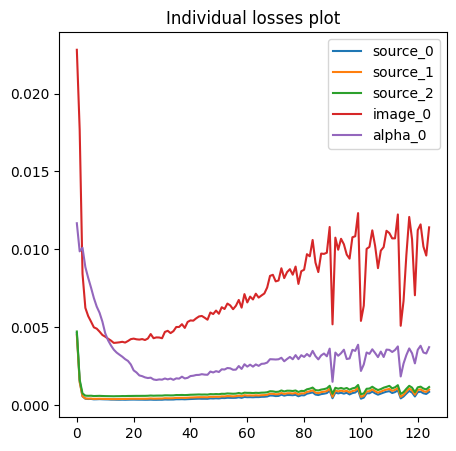

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

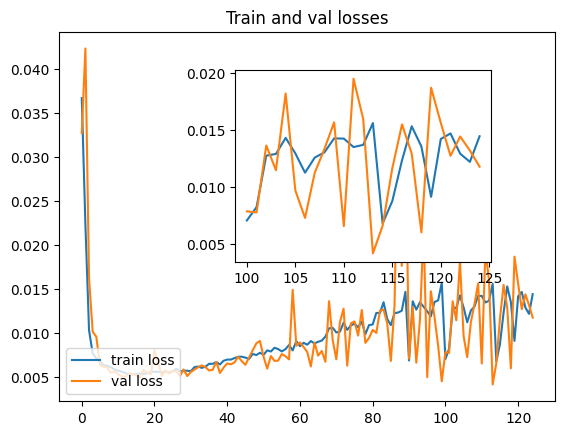

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.005215718764720448


In [ ]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [15]:
torch.save(best_weights, 'Weights_1.pt')